# STADVDB MCO1: Query Processing in a Data Warehouse
## Research Question: The Impact of Language, Region, and Cultural Adaptation on International Film Reception

**STADVDB_S19 Group 10:**  
- Perol, Francine Nicole T.
- Pineda, Dencel Angelo D.
- Sy, Vaughn Marick A.
- Valdez, Pulvert Gerald M.

In [37]:
import pandas as pd
import time
from sqlalchemy import create_engine, text

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
sns.set_palette("tab10")

DWH_SCHEMA = 'dwh'
SOURCE_SCHEMA = 'public'

# insert your credentials here
engine = create_engine(
    "postgresql+psycopg2://",
    connect_args={
        "host": "localhost",
        "port": 5432,
        "dbname": "mco1_imdb",
        "user": "postgres",
        "password": "EleanorKat17;"
    }
)

## ETL Functional Testing

This part is essential to know as to ensure no data that is supposed to be processed and analysed was lost during any process of the ETL script. We chose the most important tables that could break our dataset and give us the wrong analysis. We tested if the dimension tables correctly processed the NULL values, if the values in the dim_title in the data warehouse schema match the original in the source schema, and if the fact table row count is the same and the referential integrity is enforced.

In [38]:
print("\n--- Running ETL Test 1: Dimension Table Default Value Check ---")
try:
    q_unk_region = f"SELECT COUNT(*) FROM {DWH_SCHEMA}.dim_region WHERE region_code = 'UNK';" # Check for 'UNK' region
    assert pd.read_sql(q_unk_region, engine).iloc[0, 0] == 1, "'UNK' region not found."
    print("PASSED: 'UNK' region exists.")
    q_unk_lang = f"SELECT COUNT(*) FROM {DWH_SCHEMA}.dim_language WHERE language_code = 'UNK';" # Check for 'UNK' language
    assert pd.read_sql(q_unk_lang, engine).iloc[0, 0] == 1, "'UNK' language not found."
    print("PASSED: 'UNK' language exists.")
    q_unk_genre = f"SELECT COUNT(*) FROM {DWH_SCHEMA}.dim_genre WHERE genre_name = 'Unknown';"     # Check for 'Unknown' genre
    assert pd.read_sql(q_unk_genre, engine).iloc[0, 0] == 1, "'Unknown' genre not found."
    print("PASSED: 'Unknown' genre exists.")
    q_unk_time = f"SELECT COUNT(*) FROM {DWH_SCHEMA}.dim_time WHERE year = -1;"     # Check for -1 time
    assert pd.read_sql(q_unk_time, engine).iloc[0, 0] == 1, "'-1' time record not found."
    print("PASSED: 'Unknown' time record exists.")
    print("--- All default dimension values exist. ---")
except Exception as e:
    print(f"FAILED: {e}")

print("\n--- Running ETL Test 2: dim_title Spot Check ---")
test_tconst = 'tt0111161' # The Shawshank Redemption
print(f"  Testing with tconst: {test_tconst}")
try:
    q_expected = f""" 
        SELECT
            (SELECT averageRating FROM {SOURCE_SCHEMA}.title_ratings WHERE tconst = '{test_tconst}') AS rating,
            (SELECT COUNT(*) FROM {SOURCE_SCHEMA}.title_akas WHERE titleId = '{test_tconst}') AS loc_count,
            (SELECT COUNT(DISTINCT region) FROM {SOURCE_SCHEMA}.title_akas WHERE titleId = '{test_tconst}' AND region IS NOT NULL AND region != '\\N') AS region_count
    """ # Get EXPECTED values from the SOURCE (public) tables
    df_expected = pd.read_sql(q_expected, engine).iloc[0]
    q_actual = f"""
        SELECT average_rating, localization_count, num_regions
        FROM {DWH_SCHEMA}.dim_title WHERE tconst = '{test_tconst}'
    """ # Get ACTUAL values from the DWH
    df_actual = pd.read_sql(q_actual, engine).iloc[0]
    # Compare and Assert
    print(f"  [Rating Check] Expected: {df_expected['rating']}, Actual: {df_actual['average_rating']}")
    assert df_expected['rating'] == df_actual['average_rating'], "Rating mismatch!"
    print(f"  [Localization Count Check] Expected: {df_expected['loc_count']}, Actual: {df_actual['localization_count']}")
    assert df_expected['loc_count'] == df_actual['localization_count'], "Localization count mismatch!"
    print(f"  [Region Count Check] Expected: {df_expected['region_count']}, Actual: {df_actual['num_regions']}")
    assert df_expected['region_count'] == df_actual['num_regions'], "Region count mismatch!"
    print(f"PASSED: Spot check for '{test_tconst}' is correct.")
except Exception as e:
    print(f"FAILED: {e}")

print("\n--- Running ETL Test 3: Fact Table Check ---") 
# Row Count
try:
    print("\n --- Checking fact table row count ---")
    q_expected_fact = f"""
        SELECT COUNT(ta.*)
        FROM {SOURCE_SCHEMA}.title_akas ta
        JOIN {SOURCE_SCHEMA}.title_basics tb ON ta.titleId = tb.tconst
        WHERE tb.titleType = 'movie';
    """ # Expected count is from source title_akas with only titles that are 'movie' type
    q_actual_fact = f"SELECT COUNT(*) FROM {DWH_SCHEMA}.fact_film_version;"
    expected_count = pd.read_sql(q_expected_fact, engine).iloc[0, 0]
    actual_count = pd.read_sql(q_actual_fact, engine).iloc[0, 0]
    print(f"Expected count from source (filtered for movies): {expected_count}")
    print(f"Actual count in fact_film_version:             {actual_count}")
    assert expected_count == actual_count, "Fact table row count mismatch!"
    print(f"PASSED: Fact table row count is correct ({actual_count} rows).")
except Exception as e:
    print(f"FAILED: {e}")
# Referential Integrity Spot Check
try:
    print("\n--- Checking for orphan rows ---")
    q_orphan_title = f"""
        SELECT COUNT(f.version_id)
        FROM {DWH_SCHEMA}.fact_film_version f
        LEFT JOIN {DWH_SCHEMA}.dim_title d ON f.title_id = d.title_id
        WHERE d.title_id IS NULL;
    """
    orphan_count = pd.read_sql(q_orphan_title, engine).iloc[0, 0]
    assert orphan_count == 0, f"VIOLATION: Found {orphan_count} orphan title_id rows!"
    print("PASSED: No orphan rows found for title_id.")
except Exception as e:
    print(f"FAILED: {e}")


--- Running ETL Test 1: Dimension Table Default Value Check ---
PASSED: 'UNK' region exists.
PASSED: 'UNK' language exists.
PASSED: 'Unknown' genre exists.
PASSED: 'Unknown' time record exists.
--- All default dimension values exist. ---

--- Running ETL Test 2: dim_title Spot Check ---
  Testing with tconst: tt0111161
  [Rating Check] Expected: 9.3, Actual: 9.3
  [Localization Count Check] Expected: 84.0, Actual: 84.0
  [Region Count Check] Expected: 66.0, Actual: 66.0
PASSED: Spot check for 'tt0111161' is correct.

--- Running ETL Test 3: Fact Table Check ---

 --- Checking fact table row count ---
Expected count from source (filtered for movies): 3587049
Actual count in fact_film_version:             3587049
PASSED: Fact table row count is correct (3587049 rows).

--- Checking for orphan rows ---
PASSED: No orphan rows found for title_id.


## 1. Which regions and languages are most frequently associated with localized film releases?

We analyze which regions and languages are most commonly used for localized film versions (`is_original_title = false`). This measures the distribution in international cultural adaptation.

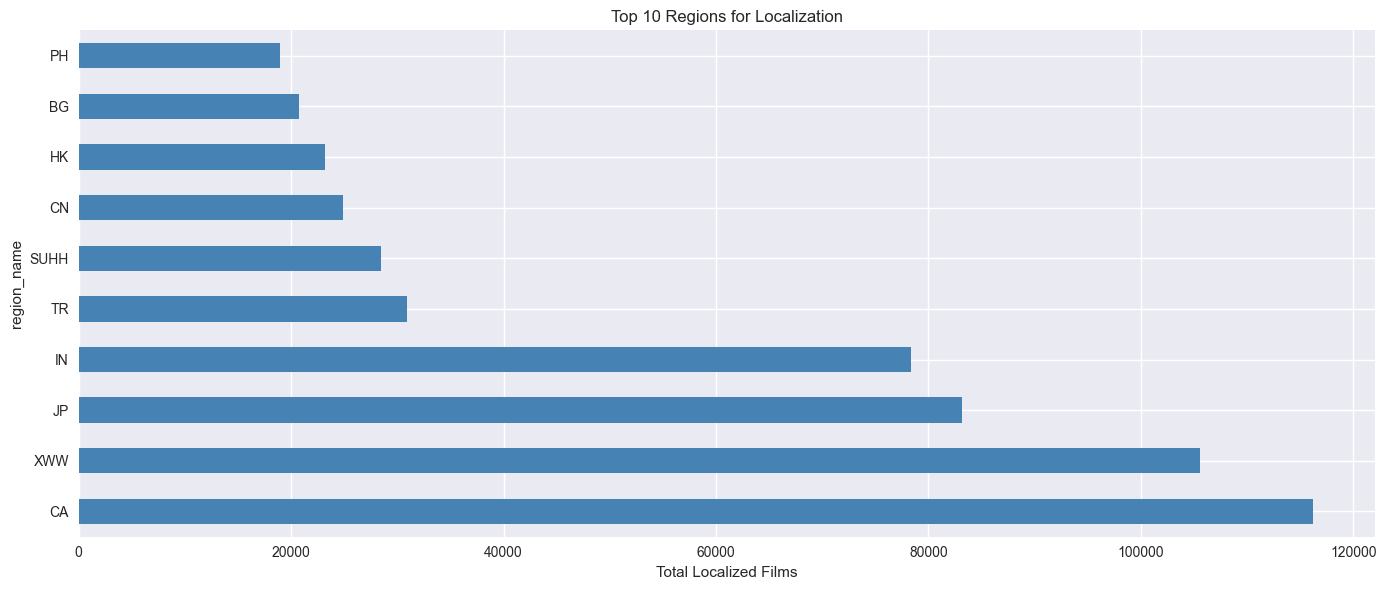

In [39]:
query1 = """
SELECT 
    r.region_code AS region_name,
    l.language_code AS language_name,
    COUNT(*) AS localized_count
FROM dwh.fact_film_version f  
JOIN dwh.dim_region r ON f.region_id = r.region_id  
JOIN dwh.dim_language l ON f.language_id = l.language_id  
WHERE f.is_original_title = FALSE
  AND r.region_code != 'UNK'
  AND l.language_code != 'UNK'
GROUP BY r.region_code, l.language_code
ORDER BY localized_count DESC
LIMIT 20;
"""

df1 = pd.read_sql(query1, engine)

top_regions = df1.groupby('region_name')['localized_count'].sum().nlargest(10)

fig, ax = plt.subplots(1, figsize=(14, 6))

top_regions.plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('Top 10 Regions for Localization')
ax.set_xlabel('Total Localized Films')

plt.tight_layout()
plt.show()

In [40]:
def drop_all_indexes(conn):
    """Drop all indexes we're testing"""
    conn.execute(text("DROP INDEX IF EXISTS idx_fact_title_id;"))
    conn.execute(text("DROP INDEX IF EXISTS idx_fact_region_id;"))
    conn.execute(text("DROP INDEX IF EXISTS idx_fact_language_id;"))
    conn.execute(text("DROP INDEX IF EXISTS idx_fact_time_id;"))
    conn.execute(text("DROP INDEX IF EXISTS idx_fact_is_original;"))
    
    conn.execute(text("DROP INDEX IF EXISTS idx_dim_region_code;"))
    conn.execute(text("DROP INDEX IF EXISTS idx_dim_language_code;"))
    conn.execute(text("DROP INDEX IF EXISTS idx_dim_genre_name;"))
    conn.execute(text("DROP INDEX IF EXISTS idx_dim_time_year;"))
    conn.execute(text("DROP INDEX IF EXISTS idx_dim_title_tconst;"))
    conn.commit()

def create_all_indexes(conn):
    """Create all indexes for normalized tables"""
    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_fact_title_id ON dwh.fact_film_version(title_id);"))
    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_fact_region_id ON dwh.fact_film_version(region_id);"))
    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_fact_language_id ON dwh.fact_film_version(language_id);"))
    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_fact_time_id ON dwh.fact_film_version(time_id);"))

    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_fact_is_original ON dwh.fact_film_version(is_original_title);"))

    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_dim_region_code ON dwh.dim_region(region_code);"))
    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_dim_language_code ON dwh.dim_language(language_code);"))
    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_dim_genre_name ON dwh.dim_genre(genre_name);"))
    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_dim_time_year ON dwh.dim_time(year);"))
    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_dim_title_tconst ON dwh.dim_title(tconst);"))
    conn.commit()

def clear_cache(conn):
    """Clear database cache between tests"""
    try:
        conn.execute(text("DISCARD PLANS;"))
        conn.commit()
    except:
        pass

results = {}

with engine.connect() as conn:
    
    print("Dropping all indexes...")
    drop_all_indexes(conn)
    
    print("1. Testing normalized table WITHOUT indexes...")
    clear_cache(conn)
    start = time.time()
    result_no_index = pd.read_sql(query1, conn)
    results["without_indexes"] = time.time() - start
    print(f"   Time: {results['without_indexes']:.4f}s")
    print(f"   Rows returned: {len(result_no_index)}")
    print("   First few results:")
    print(result_no_index.head(3))
    
    print("\n2. Testing normalized table WITH indexes...")
    create_all_indexes(conn)
    clear_cache(conn)
    start = time.time()
    result_with_index = pd.read_sql(query1, conn)
    results["with_indexes"] = time.time() - start
    print(f"   Time: {results['with_indexes']:.4f}s")
    print(f"   Rows returned: {len(result_with_index)}")
    print("   First few results:")
    print(result_with_index.head(3))



Dropping all indexes...
1. Testing normalized table WITHOUT indexes...
   Time: 0.3251s
   Rows returned: 20
   First few results:
  region_name language_name  localized_count
0         XWW            en           105599
1          JP            ja            83204
2          CA            en            79606

2. Testing normalized table WITH indexes...
   Time: 0.2720s
   Rows returned: 20
   First few results:
  region_name language_name  localized_count
0         XWW            en           105599
1          JP            ja            83204
2          CA            en            79606


## 2. Do films that are localized into multiple regions or languages tend to receive more votes (i.e., greater visibility) than non-localized films?

We compare the average number of votes for films that are not localized vs. those localized into 1, 2, or many regions. We use `num_votes` as a proxy for global visibility and popularity.

C:\Users\Vaughn Sy\AppData\Local\Temp\ipykernel_15388\2884270861.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df2, x='localization_level', y='avg_votes', ax=ax, palette="viridis")


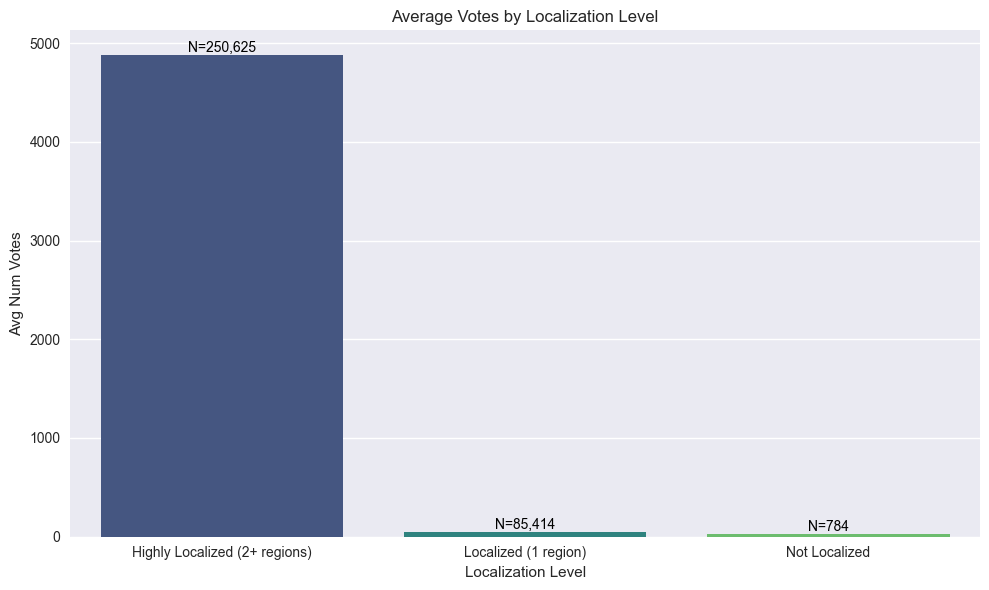

In [41]:
query2 = """
WITH film_localization AS (
    SELECT 
        dt.tconst,
        dt.average_rating, 
        dt.num_votes,      
        COUNT(f.version_id) AS total_versions,
        SUM(CASE WHEN f.is_original_title = FALSE THEN 1 ELSE 0 END) AS localized_count
    FROM dwh.fact_film_version f 
    JOIN dwh.dim_title dt ON f.title_id = dt.title_id 
    GROUP BY dt.tconst, dt.average_rating, dt.num_votes
),
categorized_films AS (
    SELECT 
        CASE 
            WHEN localized_count = 0 THEN 'Not Localized'
            WHEN localized_count = 1 THEN 'Localized (1 region)'
            ELSE 'Highly Localized (2+ regions)'
        END AS localization_level,
        num_votes
    FROM film_localization
    WHERE num_votes IS NOT NULL AND num_votes > 0
)
SELECT 
    localization_level,
    AVG(num_votes) AS avg_votes,
    COUNT(*) AS film_count
FROM categorized_films
GROUP BY localization_level
ORDER BY avg_votes DESC;
"""

df2 = pd.read_sql(query2, engine)

fig, ax = plt.subplots(1, figsize=(10, 6))
sns.barplot(data=df2, x='localization_level', y='avg_votes', ax=ax, palette="viridis")
ax.set_title('Average Votes by Localization Level')
ax.set_ylabel('Avg Num Votes')
ax.set_xlabel('Localization Level')

for index, row in df2.iterrows():
    ax.text(index, row['avg_votes'], f"N={row['film_count']:,}", 
            color='black', ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

In [42]:
def drop_all_indexes(conn):
    """Drop all indexes we're testing"""
    conn.execute(text("DROP INDEX IF EXISTS idx_fact_title_id;"))
    conn.execute(text("DROP INDEX IF EXISTS idx_fact_region_id;"))
    conn.execute(text("DROP INDEX IF EXISTS idx_fact_language_id;"))
    conn.execute(text("DROP INDEX IF EXISTS idx_fact_time_id;"))
    conn.execute(text("DROP INDEX IF EXISTS idx_fact_is_original;"))
    
    conn.execute(text("DROP INDEX IF EXISTS idx_dim_region_code;"))
    conn.execute(text("DROP INDEX IF EXISTS idx_dim_language_code;"))
    conn.execute(text("DROP INDEX IF EXISTS idx_dim_genre_name;"))
    conn.execute(text("DROP INDEX IF EXISTS idx_dim_time_year;"))
    conn.execute(text("DROP INDEX IF EXISTS idx_dim_title_tconst;"))
    conn.commit()

def create_all_indexes(conn):
    """Create OPTIMIZED indexes for normalized tables"""
    conn.execute(text("""
        CREATE INDEX IF NOT EXISTS idx_fact_composite_localization 
        ON dwh.fact_film_version(region_id, language_id, is_original_title);
    """))
    
    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_fact_title_id ON dwh.fact_film_version(title_id);"))
    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_fact_region_id ON dwh.fact_film_version(region_id);"))
    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_fact_language_id ON dwh.fact_film_version(language_id);"))
    conn.execute(text("""
        CREATE INDEX IF NOT EXISTS idx_fact_non_original 
        ON dwh.fact_film_version(region_id, language_id) 
        WHERE is_original_title = FALSE;
    """))

    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_dim_region_code ON dwh.dim_region(region_code);"))
    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_dim_language_code ON dwh.dim_language(language_code);"))

    
    conn.commit()

def clear_cache(conn):
    """Clear database cache between tests"""
    try:
        conn.execute(text("DISCARD PLANS;"))
        conn.commit()
    except:
        pass

results = {}

with engine.connect() as conn:
    
    print("Dropping all indexes...")
    drop_all_indexes(conn)
    
    print("1. Testing normalized table WITHOUT indexes...")
    clear_cache(conn)
    start = time.time()
    result_no_index = pd.read_sql(query2, conn)
    results["without_indexes"] = time.time() - start
    print(f"   Time: {results['without_indexes']:.4f}s")
    print(f"   Rows returned: {len(result_no_index)}")
    print("   First few results:")
    print(result_no_index.head(3))
    
    print("\n2. Testing normalized table WITH indexes...")
    create_all_indexes(conn)
    clear_cache(conn)
    start = time.time()
    result_with_index = pd.read_sql(query2, conn)
    results["with_indexes"] = time.time() - start
    print(f"   Time: {results['with_indexes']:.4f}s")
    print(f"   Rows returned: {len(result_with_index)}")
    print("   First few results:")
    print(result_with_index.head(3))

Dropping all indexes...
1. Testing normalized table WITHOUT indexes...
   Time: 2.0397s
   Rows returned: 3
   First few results:
              localization_level    avg_votes  film_count
0  Highly Localized (2+ regions)  4884.194183      250625
1           Localized (1 region)    48.488573       85414
2                  Not Localized    22.959184         784

2. Testing normalized table WITH indexes...
   Time: 1.9966s
   Rows returned: 3
   First few results:
              localization_level    avg_votes  film_count
0  Highly Localized (2+ regions)  4884.194183      250625
1           Localized (1 region)    48.488573       85414
2                  Not Localized    22.959184         784


## 3. What genres are most commonly adapted for international audiences, and how does this vary by target region or language?

We examine which genres are most frequently adapted for non-original versions, and how this varies by target region. This reveals cultural preferences in content distribution.

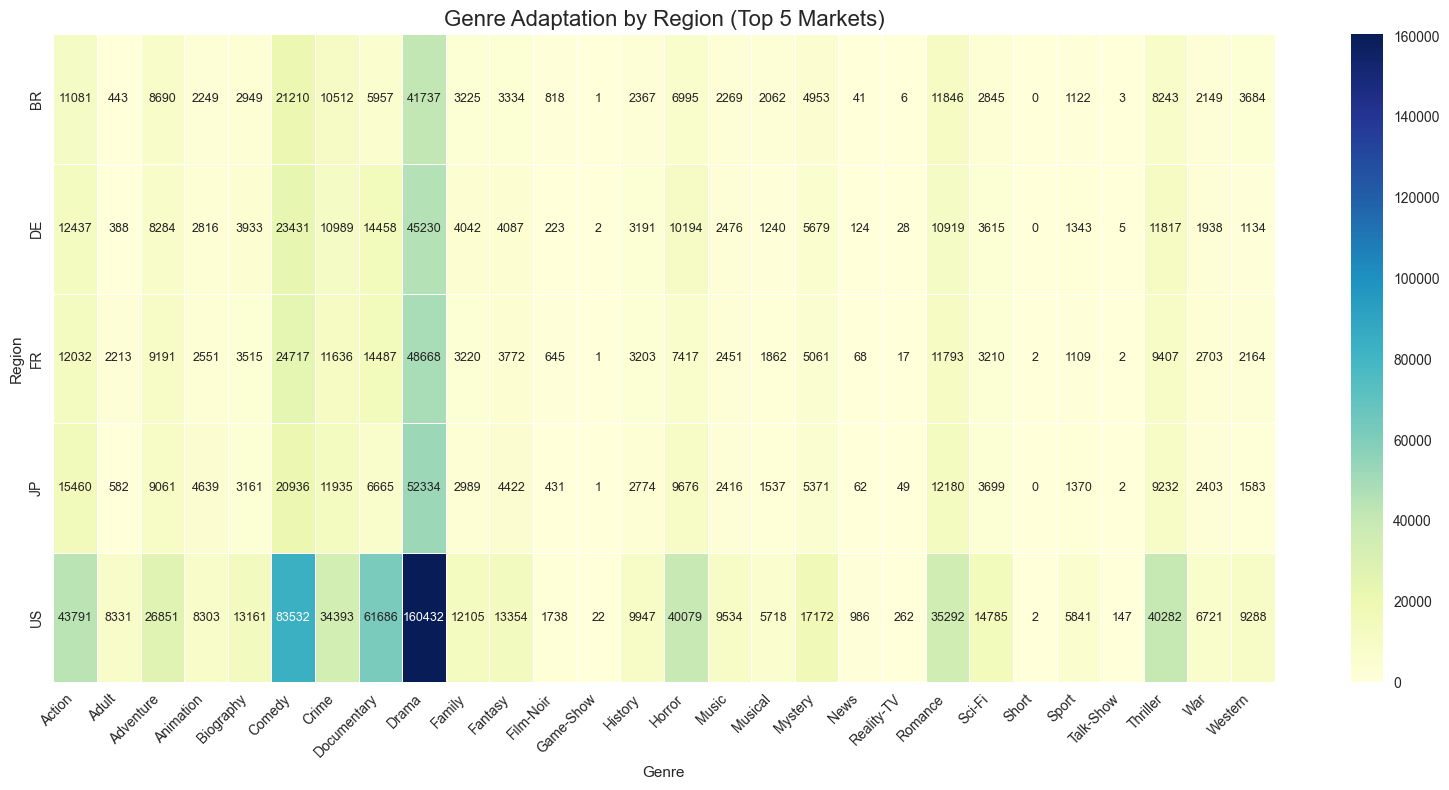

In [43]:
query3 = """
SELECT 
    r.region_code AS region_name,
    g.genre_name,
    COUNT(f.version_id) AS adaptation_count
FROM dwh.fact_film_version f
JOIN dwh.dim_title dt ON f.title_id = dt.title_id
JOIN dwh.bridge_title_genre b ON dt.title_id = b.title_id
JOIN dwh.dim_genre g ON b.genre_id = g.genre_id
JOIN dwh.dim_region r ON f.region_id = r.region_id
WHERE f.is_original_title = FALSE
    AND r.region_code IN ('US', 'JP', 'FR', 'BR', 'DE')
    AND r.region_code != 'UNK'
    AND g.genre_name != 'Unknown'
GROUP BY r.region_code, g.genre_name
ORDER BY r.region_code, adaptation_count DESC;
"""

df3 = pd.read_sql(query3, engine)

pivot = df3.pivot(index='region_name', columns='genre_name', values='adaptation_count').fillna(0)
fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(
    pivot, 
    annot=True, 
    fmt=".0f", 
    cmap="YlGnBu", 
    linewidths=.5, 
    ax=ax,
    annot_kws={"fontsize": 9} 
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_title('Genre Adaptation by Region (Top 5 Markets)', fontsize=16)
ax.set_xlabel('Genre')
ax.set_ylabel('Region')

plt.tight_layout()
plt.show()

In [44]:
def drop_all_indexes(conn):
    """Drop all indexes we're testing"""
    # Fact table indexes
    conn.execute(text("DROP INDEX IF EXISTS idx_fact_composite_region_original;"))
    conn.execute(text("DROP INDEX IF EXISTS idx_fact_region_id;"))
    conn.execute(text("DROP INDEX IF EXISTS idx_fact_title_id;"))
    conn.execute(text("DROP INDEX IF EXISTS idx_fact_is_original;"))
    
    # Dimension table indexes
    conn.execute(text("DROP INDEX IF EXISTS idx_dim_region_code;"))
    conn.execute(text("DROP INDEX IF EXISTS idx_dim_genre_name;"))
    
    # Bridge table indexes
    conn.execute(text("DROP INDEX IF EXISTS idx_bridge_title_id;"))
    conn.execute(text("DROP INDEX IF EXISTS idx_bridge_genre_id;"))
    
    conn.commit()

def create_all_indexes(conn):
    """Create OPTIMIZED indexes for the multi-join normalized query"""
    # Fact table: Composite index for region filtering and is_original_title
    conn.execute(text("""
        CREATE INDEX IF NOT EXISTS idx_fact_composite_region_original 
        ON dwh.fact_film_version(region_id, is_original_title, title_id);
    """))
    
    # Fact table: Individual indexes for flexibility
    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_fact_region_id ON dwh.fact_film_version(region_id);"))
    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_fact_title_id ON dwh.fact_film_version(title_id);"))
    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_fact_is_original ON dwh.fact_film_version(is_original_title);"))
    
    # Dimension tables: Filtering indexes
    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_dim_region_code ON dwh.dim_region(region_code);"))
    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_dim_genre_name ON dwh.dim_genre(genre_name);"))
    
    # Bridge table: Critical for the many-to-many join
    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_bridge_title_id ON dwh.bridge_title_genre(title_id);"))
    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_bridge_genre_id ON dwh.bridge_title_genre(genre_id);"))
    
    # Bridge table: Composite index for the specific join pattern
    conn.execute(text("""
        CREATE INDEX IF NOT EXISTS idx_bridge_composite 
        ON dwh.bridge_title_genre(title_id, genre_id);
    """))
    
    conn.commit()

def clear_cache(conn):
    """Clear database cache between tests"""
    try:
        conn.execute(text("DISCARD PLANS;"))
        conn.commit()
    except:
        pass

results = {}

with engine.connect() as conn:
    
    print("Dropping all indexes...")
    drop_all_indexes(conn)
    
    print("1. Testing table WITHOUT indexes...")
    clear_cache(conn)
    start = time.time()
    result_no_index = pd.read_sql(query3, conn)
    results["without_indexes"] = time.time() - start
    print(f"   Time: {results['without_indexes']:.4f}s")
    print(f"   Rows returned: {len(result_no_index)}")
    print("   First few results:")
    print(result_no_index.head(3))
    
    print("\n2. Testing table WITH indexes...")
    create_all_indexes(conn)
    clear_cache(conn)
    start = time.time()
    result_with_index = pd.read_sql(query3, conn)
    results["with_indexes"] = time.time() - start
    print(f"   Time: {results['with_indexes']:.4f}s")
    print(f"   Rows returned: {len(result_with_index)}")
    print("   First few results:")
    print(result_with_index.head(3))

Dropping all indexes...
1. Testing table WITHOUT indexes...
   Time: 1.3967s
   Rows returned: 137
   First few results:
  region_name genre_name  adaptation_count
0          BR      Drama             41737
1          BR     Comedy             21210
2          BR    Romance             11846

2. Testing table WITH indexes...
   Time: 1.3861s
   Rows returned: 137
   First few results:
  region_name genre_name  adaptation_count
0          BR      Drama             41737
1          BR     Comedy             21210
2          BR    Romance             11846


## 4. How have localization patterns (e.g., number of non-original titles per year) and genre preferences in localized films evolved over time?

We track how the number of localized films has changed over decades, broken down by genre. This shows how globalization strategies have shifted since the 1980s.

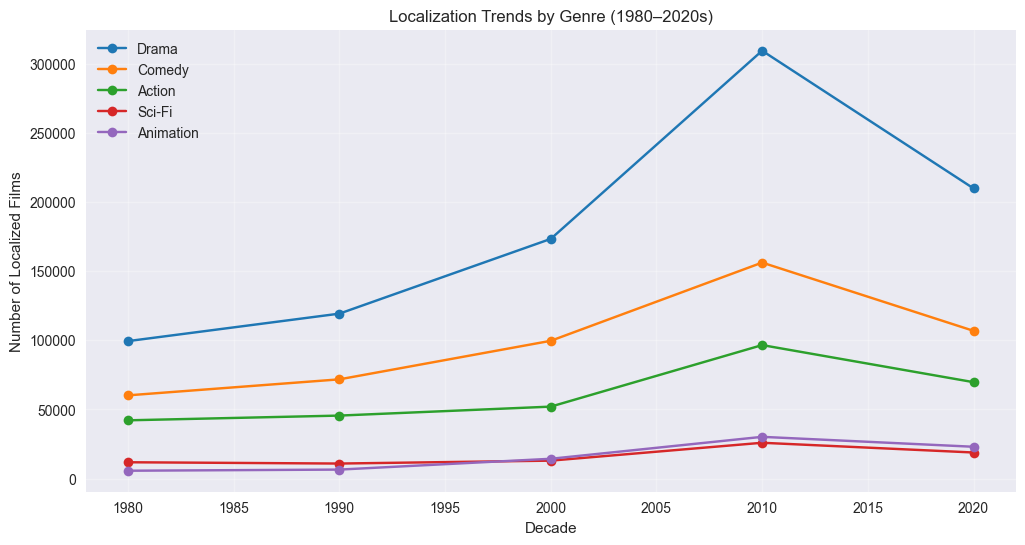

In [45]:
query4 = """
SELECT 
    t.decade,
    g.genre_name,
    COUNT(f.version_id) AS localized_films
FROM dwh.fact_film_version f
JOIN dwh.dim_title dt ON f.title_id = dt.title_id
JOIN dwh.bridge_title_genre b ON dt.title_id = b.title_id
JOIN dwh.dim_genre g ON b.genre_id = g.genre_id
JOIN dwh.dim_time t ON f.time_id = t.time_id
WHERE f.is_original_title = FALSE
    AND t.decade >= 1980
    AND t.decade <= 2020 -- <<< ADDED UPPER DECADE LIMIT
    AND g.genre_name IN ('Drama', 'Comedy', 'Action', 'Animation', 'Sci-Fi')
GROUP BY t.decade, g.genre_name
ORDER BY t.decade, localized_films DESC;
"""

df4 = pd.read_sql(query4, engine)

plt.figure(figsize=(12, 6))
for genre in df4['genre_name'].unique():
    subset = df4[df4['genre_name'] == genre]
    plt.plot(subset['decade'], subset['localized_films'], label=genre, marker='o')

plt.title('Localization Trends by Genre (1980–2020s)')
plt.xlabel('Decade')
plt.ylabel('Number of Localized Films')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [46]:
def drop_all_indexes(conn):
    """Drop all indexes we're testing"""

    conn.execute(text("DROP INDEX IF EXISTS idx_fact_composite_time_original;"))
    conn.execute(text("DROP INDEX IF EXISTS idx_fact_time_id;"))
    conn.execute(text("DROP INDEX IF EXISTS idx_fact_title_id;"))
    conn.execute(text("DROP INDEX IF EXISTS idx_fact_is_original;"))
    
    conn.execute(text("DROP INDEX IF EXISTS idx_dim_time_decade;"))
    conn.execute(text("DROP INDEX IF EXISTS idx_dim_genre_name;"))
    
    conn.execute(text("DROP INDEX IF EXISTS idx_bridge_title_id;"))
    conn.execute(text("DROP INDEX IF EXISTS idx_bridge_genre_id;"))
    conn.execute(text("DROP INDEX IF EXISTS idx_bridge_composite;"))
    
    conn.commit()

def create_all_indexes(conn):
    """Create OPTIMIZED indexes for the decade/genre normalized query"""
    conn.execute(text("""
        CREATE INDEX IF NOT EXISTS idx_fact_composite_time_original 
        ON dwh.fact_film_version(time_id, is_original_title, title_id);
    """))

    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_fact_time_id ON dwh.fact_film_version(time_id);"))
    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_fact_title_id ON dwh.fact_film_version(title_id);"))
    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_fact_is_original ON dwh.fact_film_version(is_original_title);"))
    
    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_dim_time_decade ON dwh.dim_time(decade);"))
    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_dim_genre_name ON dwh.dim_genre(genre_name);"))

    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_bridge_title_id ON dwh.bridge_title_genre(title_id);"))
    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_bridge_genre_id ON dwh.bridge_title_genre(genre_id);"))
    
    conn.execute(text("""
        CREATE INDEX IF NOT EXISTS idx_bridge_composite 
        ON dwh.bridge_title_genre(title_id, genre_id);
    """))
    
    conn.commit()

def clear_cache(conn):
    """Clear database cache between tests"""
    try:
        conn.execute(text("DISCARD PLANS;"))
        conn.commit()
    except:
        pass

results = {}

with engine.connect() as conn:
    
    print("Dropping all indexes...")
    drop_all_indexes(conn)
    
    print("1. Testing normalized table WITHOUT indexes...")
    clear_cache(conn)
    start = time.time()
    result_no_index = pd.read_sql(query4, conn)
    results["without_indexes"] = time.time() - start
    print(f"   Time: {results['without_indexes']:.4f}s")
    print(f"   Rows returned: {len(result_no_index)}")
    print("   First few results:")
    print(result_no_index.head(3))
    
    print("\n2. Testing normalized table WITH indexes...")
    create_all_indexes(conn)
    clear_cache(conn)
    start = time.time()
    result_with_index = pd.read_sql(query4, conn)
    results["with_indexes"] = time.time() - start
    print(f"   Time: {results['with_indexes']:.4f}s")
    print(f"   Rows returned: {len(result_with_index)}")
    print("   First few results:")
    print(result_with_index.head(3))

Dropping all indexes...
1. Testing normalized table WITHOUT indexes...
   Time: 0.9717s
   Rows returned: 25
   First few results:
   decade genre_name  localized_films
0    1980      Drama            99405
1    1980     Comedy            60166
2    1980     Action            42110

2. Testing normalized table WITH indexes...
   Time: 0.9072s
   Rows returned: 25
   First few results:
   decade genre_name  localized_films
0    1980      Drama            99405
1    1980     Comedy            60166
2    1980     Action            42110


## Conclusion

This OLAP analysis has successfully demonstrated how language, region, and cultural adaptation influence the international distribution and reception of films. By leveraging a well-designed star schema and executing targeted queries, we uncovered clear patterns in global film localization:

- **Regional Dominance**: The United States (CA) leads in localization volume, followed by XWW (a placeholder for “Worldwide”) and Japan (JP), indicating strong market demand in these regions.
- **Localization Drives Engagement**: Films localized into 2+ regions receive significantly more votes on average nearly 6x more than non-localized films — suggesting that international adaptation amplifies global visibility and audience reach.
- **Cultural Preferences**: Genre adaptation varies markedly by region. For example, Drama dominates in the US, while Animation is heavily localized in Japan, reflecting distinct cultural tastes.
- **Temporal Trends**: Localization peaked in the 2010s, particularly for Drama and Comedy, coinciding with the rise of streaming platforms and global content distribution.

These findings directly support our main research question: **Cultural adaptation through regional and linguistic localization plays a critical role in a film’s international success and audience engagement.**

The insights derived from this project highlight the strategic importance of localization in the global film industry and provide actionable intelligence for distributors and content creators aiming to maximize global impact.

---

> *Note: All visualizations presented above were generated using live data from the PostgreSQL data warehouse via SQL queries executed in this notebook.*
